# Identify Neighborhood Pairs
Hi there, Audrey here. In this Jupyter notebook we will use the datasets cleaned in cleannotebook-1 to identify our five neighborhood pairs for analysis. 



Import libraries and cleaned datasets:

In [19]:
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt

In [20]:
Seoul_master  = gpd.read_file('AYJ-GroupData/Seoul_master.json')
# This dataset includes Seoul's population density, job density, and commute mode by Gu data. 

In [21]:
Seoul_ride = gpd.read_file('AYJ-GroupData/Seoul_rail_ridership2.json')

In [22]:
 LA_commute = gpd.read_file('AYJ-GroupData/LA_com.json')

In [23]:
#LA_ride = gpd.read_file('AYJ-GroupData/')
LA_pop = gpd.read_file('AYJ-GroupData/LA_pop.json') 

In [24]:
LA_jobs = gpd.read_file('AYJ-GroupData/LA_jobs.json') 

The methodology we used to identify our neighborhood pairs was the following:
1. Check column data type for each dataset .info()
2. Sort by highest commute mode, ridership, population density, or job to identify the top 5 dong/Census tract. For Seoul, find the top 5 dong from simply sorting the master spreadsheet.
3. For LA, map the top 5 to locate the neighborhoods where the top Census tracts are. 

I wonder if we could build a function for this? I guess we would need to rename the indicator column. We decided not to do so because each dataset is slightly different when it comes to identifying the neighborhood. 

## Commute Mode: Transit-Oriented

##### Seoul: Highest % Commute by Transit

In [25]:
Seoul_master.head()

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
0,20200630,1101053,사직동,1,사직동,종로구,4765,49536.0,57.0,15.3,1.158538e+06,0.004113,0.042757,"POLYGON ((197702.069 453187.312, 197703.481 45..."
1,20200630,1101054,삼청동,2,삼청동,종로구,1369,4577.0,57.0,15.3,1.479250e+06,0.000925,0.003094,"POLYGON ((197980.839 455346.068, 197995.471 45..."
2,20200630,1101055,부암동,3,부암동,종로구,4348,3609.0,57.0,15.3,2.274721e+06,0.001911,0.001587,"POLYGON ((196621.073 456395.880, 196628.373 45..."
3,20200630,1101056,평창동,4,평창동,종로구,7518,3565.0,57.0,15.3,8.947324e+06,0.000840,0.000398,"POLYGON ((197800.769 459064.245, 197782.531 45..."
4,20200630,1101057,무악동,5,무악동,종로구,3203,1598.0,57.0,15.3,3.695239e+05,0.008668,0.004324,"POLYGON ((196444.745 453384.564, 196471.668 45..."


This Seoul_master dataset contains % commute by public transportation, % commute by car, population density and job density by dong, as well as the geometry of each dong. Importantly, commute data for Seoul is only available at the Gu (district) level. Thus, the dongs with the same gu have the same commute percentages. 

In [26]:
Seoul_master = Seoul_master.sort_values(['Public_transportation'], ascending=False)
Seoul_master.head(5)

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
25,20200630,1102068,중림동,27,중림동,중구,6928,5961.0,71.4,14.9,484382.005315,0.014303,0.012306,"POLYGON ((197349.942 451382.862, 197352.515 45..."
17,20200630,1102054,회현동,19,회현동,중구,1141,60990.0,71.4,14.9,897829.057910,0.001271,0.067931,"POLYGON ((198371.356 451289.000, 198396.196 45..."
31,20200630,1103051,후암동,33,후암동,용산구,4180,4151.0,71.4,14.9,865886.282328,0.004827,0.004794,"POLYGON ((198120.597 450412.602, 198120.629 45..."
30,20200630,1102073,동화동,32,동화동,중구,6404,4469.0,71.4,14.9,327041.047357,0.019582,0.013665,"POLYGON ((201694.374 451528.769, 201701.600 45..."
29,20200630,1102072,청구동,31,청구동,중구,7811,3529.0,71.4,14.9,342573.679253,0.022801,0.010301,"POLYGON ((201434.770 451090.640, 201453.950 45..."


Looks like the Dongs in 중구(Jung-gu) have the highest commute by transit rates. To pick one dong out of Jung-gu, we decided to look for the highest population or job density within this Gu. 

Declare a new variable just with dongs in Jung-gu, and look at the max population and work densities: 

In [27]:
Seoul_junggu = Seoul_master[Seoul_master['Public_transportation'] == 71.4]
Seoul_junggu.describe()

,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density
count,15.000000,15.000000,1.500000e+01,1.500000e+01,1.500000e+01,15.000000,15.000000
mean,4239.600000,26035.333333,7.140000e+01,1.490000e+01,6.608263e+05,0.008869,0.035456
std,2226.277765,29744.207870,1.470963e-14,3.677408e-15,3.285440e+05,0.007075,0.030324
min,1141.000000,3529.000000,7.140000e+01,1.490000e+01,3.197062e+05,0.001081,0.004794
25%,2581.500000,5215.000000,7.140000e+01,1.490000e+01,4.134778e+05,0.003448,0.012175
50%,4180.000000,8878.000000,7.140000e+01,1.490000e+01,5.349354e+05,0.005122,0.017618
75%,6136.500000,34412.500000,7.140000e+01,1.490000e+01,8.818577e+05,0.014342,0.059146
max,7811.000000,110677.000000,7.140000e+01,1.490000e+01,1.464690e+06,0.022801,0.100377


Max work density is greater than max population density.

Which dong in Jung-gu has the 0.100377 work density value?

In [28]:
Seoul_junggu.loc[Seoul_junggu['Work_Density'] >= 0.10037] 

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
23,20200630,1102065,신당5동,25,신당5동,중구,1385,32091.0,71.4,14.9,319706.228822,0.004332,0.100377,"POLYGON ((201866.554 451786.747, 201865.514 45..."


신당 5동, or **Sindang 5(o)-dong, Jung-gu, Seoul, 04578, South Korea,** will serve as our Seoul neighborhood for transit-oriented commute. 

##### Los Angeles: Highest % Commute by Transit 

Sort the LA_commute dataset to show top 5 Census Tracts with the highest % commute by public transportation: 

In [29]:
LA_commute.sort_values(['Percent Public transportation (excluding taxicab)'], ascending=False).head()

,geoid,Name,Total,"Car, truck, or van",Public transportation (excluding taxicab),"Percent Car, truck, or van",Percent Public transportation (excluding taxicab),geometry
1122,14000US06037403200,"Census Tract 4032, Los Angeles, CA",40.0,0.0,40.0,0.000000,100.000000,"MULTIPOLYGON (((-13116252.287 4033386.578, -13..."
569,14000US06037209402,"Census Tract 2094.02, Los Angeles, CA",2219.0,453.0,1544.0,20.414601,69.580892,"MULTIPOLYGON (((-13166856.458 4036038.687, -13..."
560,14000US06037208902,"Census Tract 2089.02, Los Angeles, CA",1478.0,379.0,859.0,25.642760,58.119080,"MULTIPOLYGON (((-13166277.485 4036510.169, -13..."
562,14000US06037208904,"Census Tract 2089.04, Los Angeles, CA",1996.0,467.0,1136.0,23.396794,56.913828,"MULTIPOLYGON (((-13165961.783 4036772.455, -13..."
536,14000US06037206300,"Census Tract 2063, Los Angeles, CA",850.0,131.0,447.0,15.411765,52.588235,"MULTIPOLYGON (((-13163575.650 4034612.267, -13..."


[Census Tract 4032](https://www.google.com/search?q=census+tract+4032&rlz=1C1DLBX_enUS788US788&oq=census+tract+4032&aqs=chrome..69i57j35i39j69i64j69i60.3448j0j7&sourceid=chrome&ie=UTF-8) in Diamond Bar purportedly boasts 100% commute by transit rate. We're suspicious that this is a typo. 

The next three Census Tracts ([2094.02](https://censusreporter.org/profiles/14000US06037209402-census-tract-209402-los-angeles-ca/), [2089.02](https://censusreporter.org/profiles/14000US06037208902-census-tract-208902-los-angeles-ca/), and [2089.04](https://censusreporter.org/profiles/14000US06037208904-census-tract-208904-los-angeles-ca/)) are all in Westlake, which seems more likely.

**Westlake** will serve as our LA neighborhood for transit-oriented commute. 

|       Neighborhood Pair      |      Seoul     | Los Angeles |
|:----------------------------:|:--------------:|:-----------:|
| Highest % Commute by Transit | Sindang 5-dong |   Westlake  |

## Commute Mode: Car-Centric

##### Seoul: Highest % Commute by Car 

In [30]:
Seoul_master = Seoul_master.sort_values(['Car'], ascending=False)
Seoul_master.head(5)

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
378,20200630,1124053,거여1동,383,거여1동,송파구,13079,62612.0,50.5,34.7,5.223156e+05,0.025040,0.119874,"POLYGON ((212607.395 444445.961, 212610.476 44..."
362,20200630,1123065,역삼2동,367,역삼2동,강남구,13468,40803.0,50.5,34.7,1.135027e+06,0.011866,0.035949,"POLYGON ((204133.836 443861.568, 204131.277 44..."
372,20200630,1123077,압구정동,377,압구정동,강남구,7482,6771.0,50.5,34.7,2.345049e+06,0.003191,0.002887,"POLYGON ((202059.684 448477.464, 202069.696 44..."
368,20200630,1123073,일원1동,373,일원1동,강남구,11863,21961.0,50.5,34.7,9.534810e+05,0.012442,0.023032,"POLYGON ((208798.400 443714.614, 208799.453 44..."
369,20200630,1123074,일원2동,374,일원2동,강남구,2682,1146.0,50.5,34.7,1.300265e+06,0.002063,0.000881,"POLYGON ((207373.256 444500.713, 207381.871 44..."


Looks like the Dongs in 강남구(Gangnam-gu) have the highest commute by car rates. To pick one dong out of Gangnam-gu, we again look for the highest population or job density within this Gu. 

Declare a new variable just with dongs in Gangnam-gu, and look at the max population and work densities: 

In [31]:
Seoul_gangnam = Seoul_master[Seoul_master['Car'] == 34.7]
Seoul_gangnam.describe()

,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density
count,22.000000,22.000000,22.0,2.200000e+01,2.200000e+01,22.000000,22.000000
mean,10637.318182,31551.636364,50.5,3.470000e+01,1.706488e+06,0.008820,0.027723
std,4654.099017,33809.987983,0.0,7.272637e-15,1.225059e+06,0.006215,0.033944
min,2682.000000,1146.000000,50.5,3.470000e+01,5.223156e+05,0.001280,0.000881
25%,7579.500000,9181.000000,50.5,3.470000e+01,1.005721e+06,0.003830,0.005414
50%,9500.000000,24431.500000,50.5,3.470000e+01,1.375107e+06,0.007532,0.018145
75%,12775.000000,40174.250000,50.5,3.470000e+01,2.307760e+06,0.012298,0.027985
max,24143.000000,156700.000000,50.5,3.470000e+01,6.367776e+06,0.025040,0.119874


Max work density is again greater than max population density.

Which dong in Gangnam-gu has the 0.119874 work density value?

In [32]:
Seoul_gangnam.loc[Seoul_gangnam['Work_Density'] >= 0.11987] 

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
378,20200630,1124053,거여1동,383,거여1동,송파구,13079,62612.0,50.5,34.7,522315.593766,0.02504,0.119874,"POLYGON ((212607.395 444445.961, 212610.476 44..."


거여1동, or **Geoyeo 1(il)-dong, Songpa-gu, Seoul, 05771, South Korea**, will serve as our Seoul neighborhood for car-centric commute. 

##### Los Angeles: Highest % Commute by Car 

In [33]:
LA_commute.sort_values(['Percent Car, truck, or van'], ascending=False).head(7)

,geoid,Name,Total,"Car, truck, or van",Public transportation (excluding taxicab),"Percent Car, truck, or van",Percent Public transportation (excluding taxicab),geometry
2328,14000US06037980014,"Census Tract 9800.14, Los Angeles, CA",9.0,9.0,0.0,100.000000,0.0,"MULTIPOLYGON (((-13164741.054 3997759.965, -13..."
2338,14000US06037980026,"Census Tract 9800.26, Los Angeles, CA",5.0,5.0,0.0,100.000000,0.0,"MULTIPOLYGON (((-13174854.541 4066507.512, -13..."
2333,14000US06037980021,"Census Tract 9800.21, Los Angeles, CA",18.0,18.0,0.0,100.000000,0.0,"MULTIPOLYGON (((-13180431.313 4064453.056, -13..."
2324,14000US06037980008,"Census Tract 9800.08, Los Angeles, CA",16.0,16.0,0.0,100.000000,0.0,"MULTIPOLYGON (((-13191656.548 4058543.673, -13..."
1521,14000US06037504102,"Census Tract 5041.02, Los Angeles, CA",9.0,9.0,0.0,100.000000,0.0,"MULTIPOLYGON (((-13142820.910 4014803.656, -13..."
747,14000US06037234200,"Census Tract 2342, Los Angeles, CA",1279.0,1271.0,0.0,99.374511,0.0,"MULTIPOLYGON (((-13173002.852 4031680.586, -13..."
2209,14000US06037910001,"Census Tract 9100.01, Los Angeles, CA",2071.0,2055.0,0.0,99.227426,0.0,"MULTIPOLYGON (((-13133222.832 4103994.682, -13..."


Looks like the top 5 Census tracts in this sort have 100% commute by car rates. That's not surprising. I used CensusReporter and [Mapping LA](http://maps.latimes.com/neighborhoods/) neighborhood designations to locate them:  
* [14000US06037504102](https://censusreporter.org/profiles/14000US06037504102-census-tract-504102-los-angeles-ca/) - Norwalk
* [14000US06037980008](https://censusreporter.org/profiles/14000US06037980008-census-tract-980008-los-angeles-ca/) - Van Nuys Airport
* [14000US06037980014](https://censusreporter.org/profiles/14000US06037980014-census-tract-980014-los-angeles-ca/) - Wilmington 
* [14000US06037980021](https://censusreporter.org/profiles/14000US06037980021-census-tract-980021-los-angeles-ca/) - Hansen Dam
* [4000US06037980026](https://censusreporter.org/profiles/14000US06037980026-census-tract-980026-los-angeles-ca/) - Goes beyond Mapping LA Map, north-adjacent to Lake Terrace

**Norwalk** will serve as our LA neighborhood for car-centric commute.

We chose Norwalk because we thought Van Nuys Airport, the harbor near Wilmington, and the Hansen Dam may present physical barriers to transit connectivity. We did not consider Census Tract 9100.01 because it extends beyond Mapping LA neighborhood boundaries. 

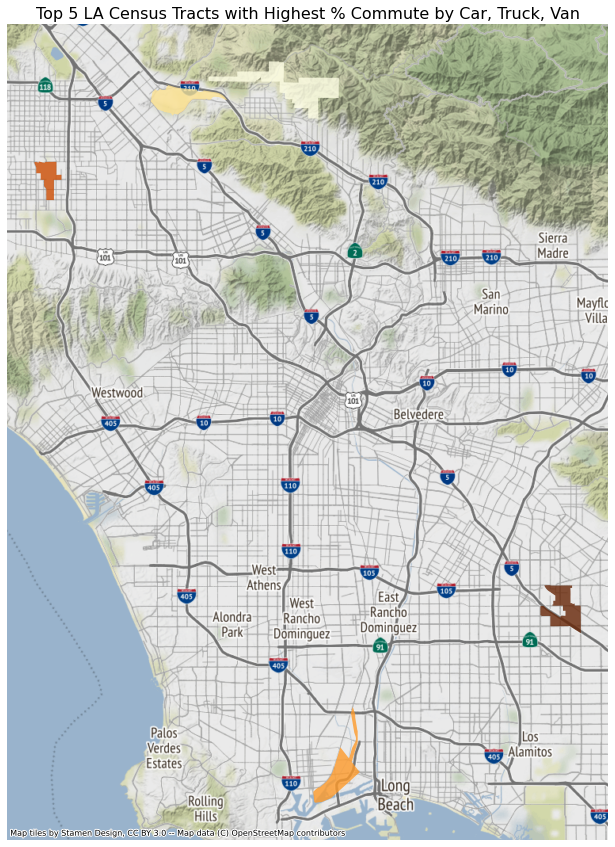

In [34]:
fig, ax = plt.subplots(figsize=(15, 15))

LA_commute[LA_commute['Percent Car, truck, or van'] >= 100].plot(ax=ax, alpha=0.8, cmap='YlOrBr_r', scheme='NaturalBreaks')

ax.axis('off')
ax.set_title('Top 5 LA Census Tracts with Highest % Commute by Car, Truck, Van',fontsize=16)

ctx.add_basemap(ax)

|       Neighborhood Pair      |      Seoul     | Los Angeles |
|:----------------------------:|:--------------:|:-----------:|
| Highest % Commute by Transit | Sindang 5-dong |   Westlake  |
| Highest % Commute by Vehicle | Geoyeo 1-dong  | Norwalk     |

## Ridership

##### Seoul: Highest Ridership Count 

This dataset, provided by a credit card company that shows aggregate daily ridership count by station from 12/1/20-12/31/20. In Korea, most people pay fares by tagging their credit cards when entering platforms. 

In [35]:
Seoul_ride.head()

,line,stn_name,st_nm,ridership,geometry
0,1호선,시청(1)역,시청(1)역,852766,POINT (198018.000 451601.000)
1,1호선,종각(1)역,종각(1)역,1309829,POINT (198343.000 452018.000)
2,1호선,동대문(1)역,동대문(1)역,504353,POINT (201032.000 452179.000)
3,1호선,동묘앞(1)역,동묘앞(1)역,423253,POINT (201444.000 452367.000)
4,1호선,신설동(1)역,신설동(1)역,613813,POINT (202246.000 452552.000)


In [36]:
Seoul_ride = Seoul_ride.sort_values(['ridership'], ascending=False)
Seoul_ride.head(5)

,line,stn_name,st_nm,ridership,geometry
26,2호선,강남(2)역,강남(2)역,3167883,POINT (202411.000 444045.000)
34,2호선,신림(2)역,신림(2)역,2799927,POINT (193594.000 442396.000)
20,2호선,잠실(2)역,잠실(2)역,2669433,POINT (208295.000 445889.000)
36,2호선,구로디지털단지(2)역,구로디지털단지(2)역,2598153,POINT (191181.000 442579.000)
24,2호선,선릉(2)역,선릉(2)역,2159338,POINT (204701.000 444915.000)


강남 2호선 Gangnam Station Line 2 has the highest onboarding rider count. This rail station is located in **Seocho-dong**, Seocho-gu, Seoul, South Korea, which will serve as our high-ridership neighborhood for Seoul.

##### Los Angeles 

Unfortunately, we don't yet have ridership data on the station level for Los Angeles. I submitted another public records request which is being processed right now. 

However, other people have done this analysis. A [Streetsblog LA article](https://la.streetsblog.org/2019/08/30/looking-for-trends-in-metros-latest-rail-ridership-numbers/) published August 2019 found the highest ridership at the following stations:

* 7th Street/Metro Center Station
* Union Station (sort of obvious)
* North Hollywood Station
* Pershing Square Station
* Wilshire Vermont Station 

I found LA Metro's [Interactive Stop Map (April 2020)](https://la-metro.maps.arcgis.com/apps/Minimalist/index.html?appid=1fd006edf4cc446cad245c72241afba5), which provides station-level ridership data. Apparently it is updated every March, July, and October of each year, but I couldn't find the July or October 2020 update... 

Anyhoo, the interactive map also shows the largest cluster of stations with >1,000 passengers Weekday Activity in Downtown Los Angeles. 

We'll analyze **DTLA** as our high ridership neighborhood for LA. 

|       Neighborhood Pair      |      Seoul     | Los Angeles |
|:----------------------------:|:--------------:|:-----------:|
| Highest % Commute by Transit | Sindang 5-dong |   Westlake  |
| Highest % Commute by Vehicle |  Geoyeo 1-dong |   Norwalk   |
|    Highest Rail Ridership    |   Seocho-dong  |     DTLA    |

## Population Density

Now that we have identified the transit-oriented and car-centric neighborhood pairs, we wanted to identify neighborhood pairs with the highest population and job density. 

Following from our evaluation of the population and area of the various jurisdictional scales of Los Angeles and Seoul, we wanted to zero into neighborhoods with similar densities. We sought to identify the neighborhoods with the highest densities because it follows that those locations should also warrant transit investments. 

| Jurisdictional Scale | City of Seoul | Seoul Capital Area |   City of LA  |   LA County   | Greater Los Angeles |
|:--------------------:|:-------------:|:------------------:|:-------------:|:-------------:|:-------------------:|
|      Population      | 9.776M (2017) |   25.514M (2017)   | 3.967M (2019) | 10.04M (2019) |    18.79M (2017)    |
|         Area         |   233 sq mi   |     4,519 sq mi    |   504 sq mi   |  4,751 sq mi  |     33,955 sq mi    |

##### Seoul: Highest Population Density

In [37]:
Seoul_master.sort_values(by=['Pop_Density'], ascending=False).head(2)

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
305,20200630,1120066,사당4동,312,사당4동,동작구,21584,8761.0,70.1,12.7,436152.789680,0.049487,0.020087,"POLYGON ((197751.748 442649.832, 197777.272 44..."
317,20200630,1121061,중앙동,324,중앙동,관악구,15762,9011.0,70.1,12.7,384719.576899,0.040970,0.023422,"POLYGON ((195368.353 443046.369, 195376.887 44..."


Sadang4-dong(사당4동), Jungang-dong(중앙동), Singil5-dong(신길5동), Singil4-dong(신길4동), Dongam1-dong(돈암1동) have the highest population densities. 

Sadang 4-dong should serve as our Seoul neighborhood for the highest population density. However, amidst our OSMnx analysis, we found that Sadang 4-dong is missing a 'highway' column. Thus, we'll ultimately use **Jungang-dong** (only 0.009 percentage points lower) as our high population density neighborhood.  

##### Los Angeles: Highest Population Density

In [38]:
LA_pop = LA_pop.sort_values(by='pop_density',ascending = False)
LA_pop.head()

,geoid,name,population,area,pop_density,geometry
565,14000US06037209104,"Census Tract 2091.04, Los Angeles, CA",2560.0,102184.690976,0.025053,"MULTIPOLYGON (((-13165586.637 4036865.708, -13..."
562,14000US06037208904,"Census Tract 2089.04, Los Angeles, CA",3978.0,163747.799715,0.024293,"MULTIPOLYGON (((-13165961.783 4036772.455, -13..."
595,14000US06037211922,"Census Tract 2119.22, Los Angeles, CA",3269.0,135711.661195,0.024088,"MULTIPOLYGON (((-13168723.286 4038075.108, -13..."
848,14000US06037265303,"Census Tract 2653.03, Los Angeles, CA",5156.0,216219.006628,0.023846,"MULTIPOLYGON (((-13186349.837 4038248.063, -13..."
133,14000US06037119340,"Census Tract 1193.40, Los Angeles, CA",4264.0,179150.167014,0.023801,"MULTIPOLYGON (((-13186188.757 4060150.831, -13..."


[Census Tract 2091.04](https://censusreporter.org/profiles/14000US06037209104-census-tract-209104-los-angeles-ca/) and  [Census Tract 2089.04](https://censusreporter.org/profiles/14000US06037208904-census-tract-208904-los-angeles-ca/) in Westlake. Since we are already analyzing Westlake, we decided to analyze the third highest population-dense [Census Tract 2119.22](https://censusreporter.org/profiles/14000US06037211922-census-tract-211922-los-angeles-ca/) in **Koreatown**. 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |

## Job Density

##### Seoul: Highest Job Density

In [39]:
Seoul_master.sort_values(by=['Work_Density'], ascending=False).head()

,BASE_DATE,ADM_DR_CD,ADM_DR_NM,OBJECTID,Dong,Gu,Population,Number of workers,Public_transportation,Car,area,Pop_Density,Work_Density,geometry
286,20200630,1119065,신길3동,293,신길3동,영등포구,13800,157954.0,48.3,28.6,5.200768e+05,0.026535,0.303713,"POLYGON ((192071.388 445688.241, 192088.787 44..."
7,20200630,1101063,종로5·6가동,9,종로5·6가동,종로구,5234,109824.0,57.0,15.3,6.031645e+05,0.008678,0.182080,"POLYGON ((200757.039 453017.729, 200756.917 45..."
276,20200630,1118058,시흥2동,283,시흥2동,금천구,15497,164278.0,51.6,23.8,1.308886e+06,0.011840,0.125510,"POLYGON ((192669.190 439779.888, 192681.029 43..."
263,20200630,1117067,오류1동,270,오류1동,구로구,13176,87533.0,52.5,29.4,7.274095e+05,0.018114,0.120335,"POLYGON ((185851.422 444479.100, 185857.294 44..."
378,20200630,1124053,거여1동,383,거여1동,송파구,13079,62612.0,50.5,34.7,5.223156e+05,0.025040,0.119874,"POLYGON ((212607.395 444445.961, 212610.476 44..."


Singil3-dong(신길3동), Jongro5,6ga-dong(종로5,6가동), Siheung2-dong(시흥2동), Oryu1-dong(오류1동), Geoyeo1-dong(거여1동) is top5 region for number of workers. 

**Singil 3-dong** will serve as our Seoul neighborhood with the highest Job Density. 

##### Los Angeles: Highest Job Density

Our LA job data is from OnTheMap. Unfortunately, this point dataset only provides the raw job count. While we did figure out how to spatial join this job point data to the LA population Census Tract data, the resulting dataframe shows several features for each Census Tract because there are multiple LA_job data points that fall within each Census Tract: 

In [40]:
LA_master = gpd.sjoin(LA_pop, LA_jobs, how = "inner", op="intersects")
LA_master.head()

,geoid,name,population,area,pop_density,geometry,index_right,GEOID,Job Count
565,14000US06037209104,"Census Tract 2091.04, Los Angeles, CA",2560.0,102184.690976,0.025053,"MULTIPOLYGON (((-13165586.637 4036865.708, -13...",33722,060372091041001,145.0
565,14000US06037209104,"Census Tract 2091.04, Los Angeles, CA",2560.0,102184.690976,0.025053,"MULTIPOLYGON (((-13165586.637 4036865.708, -13...",33721,060372091041002,36.0
565,14000US06037209104,"Census Tract 2091.04, Los Angeles, CA",2560.0,102184.690976,0.025053,"MULTIPOLYGON (((-13165586.637 4036865.708, -13...",38997,060372091041000,40.0
562,14000US06037208904,"Census Tract 2089.04, Los Angeles, CA",3978.0,163747.799715,0.024293,"MULTIPOLYGON (((-13165961.783 4036772.455, -13...",33718,060372089041000,35.0
562,14000US06037208904,"Census Tract 2089.04, Los Angeles, CA",3978.0,163747.799715,0.024293,"MULTIPOLYGON (((-13165961.783 4036772.455, -13...",29062,060372089042001,68.0


In [41]:
LA_master.shape

(63568, 9)

We do want to combine the raw job count data by Census Tract so that there's only one row for each Census Tract. We didn't have time to figure that out, so this Jupyter notebook will just look at the LA_jobs dataset on its own. 

In [42]:
LA_jobs = LA_jobs.sort_values(by= 'Job Count', ascending = False)
LA_jobs

,GEOID,Job Count,geometry
30335,060372074001016,75675.0,POINT (-13163155.954 4036353.816)
63535,060373104003007,59345.0,POINT (-13173651.681 4056205.833)
54223,060371437001000,35628.0,POINT (-13175530.947 4047350.880)
54167,060372655101002,24342.0,POINT (-13185170.776 4036601.892)
61524,060373105011027,24164.0,POINT (-13172933.284 4054516.553)
...,...,...,...
35318,060372625013007,1.0,POINT (-13194068.706 4035521.535)
35323,060372625013018,1.0,POINT (-13193956.172 4035548.820)
35327,060372625013012,1.0,POINT (-13192923.636 4035780.201)
35339,060372626043007,1.0,POINT (-13198031.250 4034561.928)


Again, this is point data so the GEOID is not a Census Tract. So we mapped the top 5 job count data points to see which they neighborhoods they land on: 

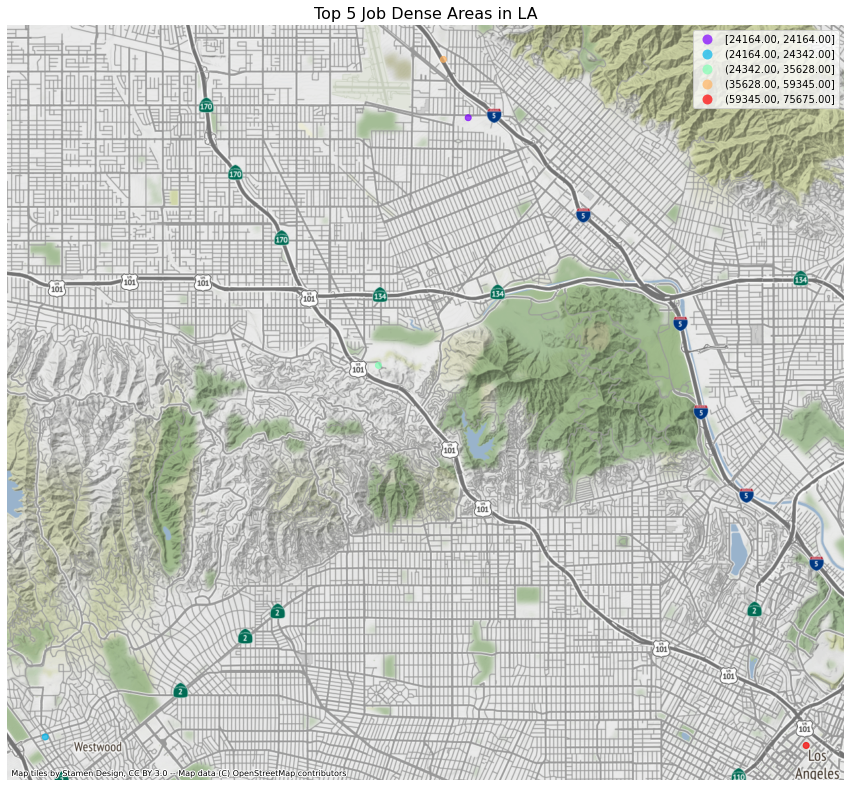

In [44]:
fig, ax = plt.subplots(figsize=(15, 15))
# 0.036165 is the pop_density value of the Top 5th region.
LA_jobs[LA_jobs['Job Count'] >= 24164].plot(ax=ax, 
                                                                        alpha=0.7, 
                                                                        column='Job Count',
                                                                        legend = True,
                                                                        cmap='rainbow', 
                                                                        scheme='NaturalBreaks')

ax.axis('off')
ax.set_title("Top 5 Job Dense Areas in LA", fontsize=16)

ctx.add_basemap(ax)

And we have the top job-dense neighborhoods in LA: 
1. Downtown LA 
2. Burbank 
3. Universal City Hollywood
4. Westwood
5. Burbank

We are already examining DTLA, so **Burbank** will serve as our LA neighborhood with high job density. 

|       Neighborhood Pair      |             Seoul            |      Los Angeles     |
|:----------------------------:|:----------------------------:|:--------------------:|
| Highest % Commute by Transit |        Sindang 5-dong        |       Westlake       |
| Highest % Commute by Vehicle |         Geoyeo 1-dong        |        Norwalk       |
|    Highest Rail Ridership    |          Seocho-dong         |         DTLA         |
|  Highest Population Density  | Sadang 4-dong / Jungang-dong | Westlake / Koreatown |
|      Highest Job Density     |         Singil 3-dong        |    DTLA / Burbank    |

In the next Jupyter notebook, Shinah will generate some fun maps and charts for these neighborhood pairs. 